# Transparent Unfairness - How to Use the Functions from fairdetect_functions.py
## An approach to detecting and understanding machine learning bias.

Congregating the various theoretical concepts into a practical framework, we can follow the “theoretical lens of a ‘sense-plan-act’ cycle”, as described by the HLEG framework (European Commission and Directorate-General for Communications Networks, Content and Technology, 2019). Applying this concept to the problem of ML fairness, we can break down three core steps in providing robust, and responsible artificial intelligence: Identify, Understand, and Act (IUA).

1. __Identify__: The process of exposing direct or indirect biases within a dataset and/or model.
1. __Understand__: The process of isolating impactful scenarios and obtaining trans parent explanations for outcomes.
1. __Act__: The process of reporting and rectifying identified disparities within the


By understanding the philosophical forms of unfairness as defined by our review of the literature and categorizing our prominent fairness metrics into the overarching categories of representation, ability, and performance, we can establish a series of tests to “identify” levels of disparities between sensitive groups at different levels. Merging these findings with the explainability of our models through the use of white-box models, or Shapley value estimation for black-box models, we can dig deeper into the model’s predictions, “understanding” how classifications were made, and how they varied from the natural dataset exposing both natural biases as well as added model differences. Finally, by probing further into levels of misclassification, in particular looking at negative outcomes, we can isolate groups most at risk and set up a series of “actions” that can be taken to mitigate the effects. Given this three-step framework which combines societal, legal, and technical considerations, the paper will then go through a series of cases, and examine the proposed framework.

# Let's use fairdetect_functions to find biases
For using fairdetect_functions we need create a model, for this we will:
1. __load the functions__ from fairdetect_functions
1. then __load a dataset__, in this case we will use: german dataser from https://dalex.drwhy.ai/python/api/datasets/index.html
/  Dataset 'german' contains information about people and their credit risk. On the base of age, purpose, credit amount, job, sex, etc. the model should predict the target - risk. risk tells if the credit rate will be good (1) or bad (0). This data contains some bias and it can be detected using the dalex.fairness module.
1. then __clean and prepare the dataset__ for modeling, in this case we only need to apply label enconding in order to transform text into numeric variables.
1. then we __split the data in train and test sets__
1. then we __build a model__, in this case we applying a Machine Learning (ML) model called XGBoost Classifier. The reason for choosing a ML is that ML models are harded to visualize, sometimes called Black Box models, what makes very difficult to see if any bias is present in the model.


In [22]:
def create_labels(X_test,sensitive):
    sensitive_label = {}
    for i in set(X_test[sensitive]):
        text = "Please Enter Label for Group" +" "+ str(i)+": "
        label = input(text)
        sensitive_label[i]=label
    return(sensitive_label)



        


def ability(sens_df,labels):
    sens_conf = {}
    for i in labels:
        sens_conf[labels[i]] = confusion_matrix(list(sens_df[labels[i]]['t']), list(sens_df[labels[i]]['p']), labels=[0,1]).ravel()
    
    true_positive_rate = {}
    false_positive_rate = {}
    true_negative_rate = {}
    false_negative_rate = {}
    
    for i in labels:
        true_positive_rate[labels[i]] = (sens_conf[labels[i]][3]/(sens_conf[labels[i]][3]+sens_conf[labels[i]][2]))
        false_positive_rate[labels[i]] = (sens_conf[labels[i]][1]/(sens_conf[labels[i]][1]+sens_conf[labels[i]][0]))
        true_negative_rate[labels[i]] = 1 - false_positive_rate[labels[i]]
        false_negative_rate[labels[i]] = 1 - true_positive_rate[labels[i]]
   
    return(true_positive_rate,false_positive_rate,true_negative_rate,false_negative_rate)



def ability_plots(labels,TPR,FPR,TNR,FNR):
    fig = make_subplots(rows=2, cols=2, 
                        subplot_titles=("True Positive Rate", "False Positive Rate", "True Negative Rate", "False Negative Rate"))

    x_axis = list(labels.values())
    fig.add_trace(
        go.Bar(x = x_axis, y=list(TPR.values())),
        row=1, col=1
    )

    fig.add_trace(
        go.Bar(x = x_axis, y=list(FPR.values())),
        row=1, col=2
    )

    fig.add_trace(
        go.Bar(x = x_axis, y=list(TNR.values())),
        row=2, col=1
    )

    fig.add_trace(
        go.Bar(x = x_axis, y=list(FNR.values())),
        row=2, col=2
    )

    fig.update_layout(showlegend=False,height=600, width=800, title_text="Ability Disparities")
    fig.show()

def ability_metrics(TPR,FPR,TNR,FNR):
    TPR_p = chisquare(list(np.array(list(TPR.values()))*100))[1]
    FPR_p = chisquare(list(np.array(list(FPR.values()))*100))[1]
    TNR_p = chisquare(list(np.array(list(TNR.values()))*100))[1]
    FNR_p = chisquare(list(np.array(list(FNR.values()))*100))[1]

    if TPR_p <= 0.01:
        print("*** Reject H0: Significant True Positive Disparity with p=",TPR_p)
    elif TPR_p <= 0.05:
        print("** Reject H0: Significant True Positive Disparity with p=",TPR_p)
    elif TPR_p <= 0.1:
        print("*  Reject H0: Significant True Positive Disparity with p=",TPR_p)
    else:
        print("Accept H0: True Positive Disparity Not Detected. p=",TPR_p)

    if FPR_p <= 0.01:
        print("*** Reject H0: Significant False Positive Disparity with p=",FPR_p)
    elif FPR_p <= 0.05:
        print("** Reject H0: Significant False Positive Disparity with p=",FPR_p)
    elif FPR_p <= 0.1:
        print("*  Reject H0: Significant False Positive Disparity with p=",FPR_p)
    else:
        print("Accept H0: False Positive Disparity Not Detected. p=",FPR_p)

    if TNR_p <= 0.01:
        print("*** Reject H0: Significant True Negative Disparity with p=",TNR_p)
    elif TNR_p <= 0.05:
        print("** Reject H0: Significant True Negative Disparity with p=",TNR_p)
    elif TNR_p <= 0.1:
        print("*  Reject H0: Significant True Negative Disparity with p=",TNR_p)
    else:
        print("Accept H0: True Negative Disparity Not Detected. p=",TNR_p)

    if FNR_p <= 0.01:
        print("*** Reject H0: Significant False Negative Disparity with p=",FNR_p)
    elif FNR_p <= 0.05:
        print("** Reject H0: Significant False Negative Disparity with p=",FNR_p)
    elif FNR_p <= 0.1:
        print("*  Reject H0: Significant False Negative Disparity with p=",FNR_p)
    else:
        print("Accept H0: False Negative Disparity Not Detected. p=",FNR_p)




def predictive(labels,sens_df):
    precision_dic = {}

    for i in labels:
        precision_dic[labels[i]] = precision_score(sens_df[labels[i]]['t'],sens_df[labels[i]]['p'])

    fig = go.Figure([go.Bar(x=list(labels.values()), y=list(precision_dic.values()))])
    
    pred_p = chisquare(list(np.array(list(precision_dic.values()))*100))[1]
    
    return(precision_dic,fig,pred_p)




def identify_bias(model,X_test,y_test,sensitive,labels):
    predictions = model.predict(X_test)
    cont_table,sens_df,rep_fig,rep_p = representation(X_test,y_test,sensitive,labels,predictions)

    print("REPRESENTATION")
    rep_fig.show()

    print(cont_table,'\n')

    if rep_p <= 0.01:
        print("*** Reject H0: Significant Relation Between",sensitive,"and Target with p=",rep_p)
    elif rep_p <= 0.05:
        print("** Reject H0: Significant Relation Between",sensitive,"and Target with p=",rep_p)
    elif rep_p <= 0.1:
        print("* Reject H0: Significant Relation Between",sensitive,"and Target with p=",rep_p)
    else:
        print("Accept H0: No Significant Relation Between",sensitive,"and Target Detected. p=",rep_p)

    TPR, FPR, TNR, FNR = ability(sens_df,labels)
    print("\n\nABILITY")
    ability_plots(labels,TPR,FPR,TNR,FNR)
    ability_metrics(TPR,FPR,TNR,FNR)


    precision_dic, pred_fig, pred_p = predictive(labels,sens_df)
    print("\n\nPREDICTIVE")
    pred_fig.show()

    if pred_p <= 0.01:
        print("*** Reject H0: Significant Predictive Disparity with p=",pred_p)
    elif pred_p <= 0.05:
        print("** Reject H0: Significant Predictive Disparity with p=",pred_p)
    elif pred_p <= 0.1:
        print("* Reject H0: Significant Predictive Disparity with p=",pred_p)
    else:
        print("Accept H0: No Significant Predictive Disparity. p=",pred_p)


def understand_shap(X_test,y_test,model,labels,sensitive,affected_group,affected_target):
    import shap
    explainer = shap.Explainer(model)
    
    full_table = X_test.copy()
    full_table['t'] = y_test
    full_table['p'] = model.predict(X_test)
    full_table

    shap_values = explainer(X_test)
    sens_glob_coh = np.where(X_test[sensitive]==list(labels.keys())[0],labels[0],labels[1])
    
    misclass = full_table[full_table.t != full_table.p]
    affected_class = misclass[(misclass[sensitive] == affected_group) & (misclass.p == affected_target)]
    shap_values2 = explainer(affected_class.drop(['t','p'],axis=1))
    #sens_mis_coh = np.where(affected_class[sensitive]==list(labels.keys())[0],labels[0],labels[1])


    figure,axes = plt.subplots(nrows=2, ncols=2,figsize=(20,10))
    plt.subplots_adjust(right=1.4,wspace=1)
    
    print("Model Importance Comparison")
    plt.subplot(1, 2, 1) # row 1, col 2 index 1
    shap.plots.bar(shap_values.cohorts(sens_glob_coh).abs.mean(0),show=False)
    plt.subplot(1, 2, 2) # row 1, col 2 index 1
    shap_values2 = explainer(affected_class.drop(['t','p'],axis=1))
    shap.plots.bar(shap_values2)
    #shap.plots.bar(shap_values2)
    
    full_table['t'] = y_test
    full_table['p'] = model.predict(X_test)
    #full_table=full_table[['checking_account','credit_amount','duration','sex','t','p']]

    misclass = full_table[full_table.t != full_table.p]
    affected_class = misclass[(misclass[sensitive] == affected_group) & (misclass.p == affected_target)]

    truclass = full_table[full_table.t == full_table.p]
    tru_class = truclass[(truclass[sensitive] == affected_group) & (truclass.t == affected_target)]

    x_axis = list(affected_class.drop(['t','p',sensitive],axis=1).columns)
    affect_character = list((affected_class.drop(['t','p',sensitive],axis=1).mean()-tru_class.drop(['t','p',sensitive],axis=1).mean())/affected_class.drop(['t','p',sensitive],axis=1).mean())

    #plt.figsize([10,10])
    #plt.bar(x_axis,affect_character)

    fig = go.Figure([go.Bar(x=x_axis, y=affect_character)])
    
    print("Affected Attribute Comparison")
    print("Average Comparison to True Class Members")
    fig.show()
    
    misclass = full_table[full_table.t != full_table.p]
    affected_class = misclass[(misclass[sensitive] == affected_group) & (misclass.p == affected_target)]

    #truclass = full_table[full_table.t == full_table.p]
    tru_class = full_table[(full_table[sensitive] == affected_group) & (full_table.p == affected_target)]

    x_axis = list(affected_class.drop(['t','p',sensitive],axis=1).columns)
    affect_character = list((affected_class.drop(['t','p',sensitive],axis=1).mean()-full_table.drop(['t','p',sensitive],axis=1).mean())/affected_class.drop(['t','p',sensitive],axis=1).mean())

    #plt.figsize([10,10])
    #plt.bar(x_axis,affect_character)

    fig = go.Figure([go.Bar(x=x_axis, y=affect_character)])
    print("Average Comparison to All Members")
    fig.show()
    
    print("Random Affected Decision Process")
    explainer = shap.Explainer(model)
    shap.plots.waterfall(explainer(affected_class.drop(['t','p'],axis=1))[randrange(0, len(affected_class))],show=False)

In [36]:
class Representation:

    def representation(X_test,y_test,sensitive,labels,predictions):
        full_table = X_test.copy()
        sens_df = {}

        for i in labels:
            full_table['p'] = predictions
            full_table['t'] = y_test
            sens_df[labels[i]] = full_table[full_table[sensitive]==i]

        contigency_p = pd.crosstab(full_table[sensitive], full_table['t']) 
        cp, pp, dofp, expectedp = chi2_contingency(contigency_p) 
        contigency_pct_p = pd.crosstab(full_table[sensitive], full_table['t'], normalize='index')

        sens_rep = {}
        for i in labels:
            sens_rep[labels[i]] = (X_test[sensitive].value_counts()/X_test[sensitive].value_counts().sum())[i]

        labl_rep = {}
        for i in labels:
            labl_rep[str(i)] = (y_test.value_counts()/y_test.value_counts().sum())[i]


        fig = make_subplots(rows=1, cols=2)

        for i in labels:
            fig.add_trace(go.Bar(
            showlegend=False,
            x = [labels[i]],
            y= [sens_rep[labels[i]]]),row=1,col=1)

            fig.add_trace(go.Bar(
            showlegend=False,
            x = [str(i)],
            y= [labl_rep[str(i)]],
            marker_color=['orange','blue'][i]),row=1,col=2)

        c, p, dof, expected = chi2_contingency(contigency_p)
        cont_table = (tabulate(contigency_pct_p.T, headers=labels.values(), tablefmt='fancy_grid'))

        return cont_table, sens_df, fig, p

In [23]:
!pip install dalex

In [24]:
!pip install tabulate

In [25]:
import matplotlib.pyplot as plt
from random import randrange
import numpy as np
import pandas as pd
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import dalex as dx
import pandas as pd
from scipy.stats import chi2_contingency
from tabulate import tabulate
from sklearn.metrics import confusion_matrix
from scipy.stats import chisquare
from sklearn.metrics import precision_score

In [26]:
import fairdetect_functions as fd

In [27]:
import dalex as dx
import pandas as pd
data = dx.datasets.load_german()
data

,risk,sex,job,housing,saving_accounts,checking_account,credit_amount,duration,purpose,age
0,1,male,2,own,not_known,little,1169,6,radio/TV,67
1,0,female,2,own,little,moderate,5951,48,radio/TV,22
2,1,male,1,own,little,not_known,2096,12,education,49
3,1,male,2,free,little,little,7882,42,furniture/equipment,45
4,0,male,2,free,little,little,4870,24,car,53
...,...,...,...,...,...,...,...,...,...,...
995,1,female,1,own,little,not_known,1736,12,furniture/equipment,31
996,1,male,3,own,little,little,3857,30,car,40
997,1,male,2,own,little,not_known,804,12,radio/TV,38
998,0,male,2,free,little,little,1845,45,radio/TV,23


# Data Cleaning
## Transforming/coding text into numbers

In [28]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
data['sex'] = le.fit_transform(data['sex'])
data['housing'] = le.fit_transform(data['housing'])
data['saving_accounts'] = le.fit_transform(data['saving_accounts'])
data['checking_account'] = le.fit_transform(data['checking_account'])
data['purpose'] = le.fit_transform(data['purpose'])
data

,risk,sex,job,housing,saving_accounts,checking_account,credit_amount,duration,purpose,age
0,1,1,2,1,2,0,1169,6,5,67
1,0,0,2,1,0,1,5951,48,5,22
2,1,1,1,1,0,2,2096,12,3,49
3,1,1,2,0,0,0,7882,42,4,45
4,0,1,2,0,0,0,4870,24,1,53
...,...,...,...,...,...,...,...,...,...,...
995,1,0,1,1,0,2,1736,12,4,31
996,1,1,3,1,0,0,3857,30,1,40
997,1,1,2,1,0,2,804,12,5,38
998,0,1,2,0,0,0,1845,45,5,23


## Splitting the data into train and test

In [29]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
X = data.drop(["risk"],axis=1) # axis: {0 or ‘index’, 1 or ‘columns’}, default 0
y = data["risk"]

X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.8, test_size=0.2, random_state=0)
print("Data sucessfully loaded!")

Data sucessfully loaded!


## Trainning a machine learning model

In [30]:
!pip install xgboost

In [31]:
import xgboost
model = xgboost.XGBClassifier().fit(X_train, y_train)
y_test_predict = model.predict(X_test)
y_test_predict

array([0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0,
       1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1,
       1, 1])

## Using FairDetect to test biases in the 'sex' variable

In [32]:
sensitive = 'sex' # sensible variable one wants to test for biases
labels = {0:'Female',1:'Male'} # 0 - Female and 1 - Male
fd.identify_bias(model,X_test,y_test,'sex',labels)

REPRESENTATION


╒════╤══════════╤══════════╕
│    │   Female │     Male │
╞════╪══════════╪══════════╡
│  0 │ 0.347222 │ 0.257812 │
├────┼──────────┼──────────┤
│  1 │ 0.652778 │ 0.742188 │
╘════╧══════════╧══════════╛ 

Accept H0: No Significant Relation Between sex and Target Detected. p= 0.23990131169226664


ABILITY


Accept H0: True Positive Disparity Not Detected. p= 0.43593930807521697
Accept H0: False Positive Disparity Not Detected. p= 0.5942718834339058
Accept H0: True Negative Disparity Not Detected. p= 0.5576362423438422
** Reject H0: Significant False Negative Disparity with p= 0.016167046868271105


PREDICTIVE


Accept H0: No Significant Predictive Disparity. p= 0.786326136425535


In our case study of the German Credit Risk dataset, we are provided with nine, fact-based features to determine whether a candidate is a high credit risk. Among this dataset are two main sensitive groups, sex, and age. For this particular analysis, we will focus on sex as being our sensitive group. To generate predictions, we will use an XGBoost classifier which received an overall test accuracy of (76%) indicating moderate predictive performance.

we will begin by observing representation factors by firstly looking at the representation of both the sex labels and outcome labels. We can see that there are a lot more males than females in the dataset, and in general, more people are labeled as being of high credit risk. This may indicate that our model will have more opportunities to train on such subgroups.

REPRESENTATION

<table>
    
   <tr>
       <td></td>
       <td>Female</td>
       <td>Male</td>
    </tr>
   <tr>
       <td>0</td>
       <td>0.347222</td>
       <td>0.25781</td>
    </tr>
   <tr>
       <td>1</td>
       <td>0.652778</td>
       <td>0.74218</td>
    </tr>    
</table>

Finally, testing for demographic parity, we look at the normalized contingency table between our sex categories and the associated predicted risk, running our chisquared assessment we obtain a p of .823, accepting our null hypothesis of independence and indicating no significant relation between the sex and the risk classification. In addition, running the same analysis on our base dataset provides us with a p of .239, once again indicating no major dependencies of the sensitive variable on the target label. Moving then into the principle of ability, we compute our true-positive and false-positive rates.

* True Positive Rate for Males 85.26%
* True Positive Rate for Females 95.74%

Based on our true positive rates, it seems as though we have a small difference be tween sensitive groups, however, running our chi-squared test, we obtain a p of .436, accepting our null, and indicating no significant difference between our true positive rates. This would thus satisfy equal opportunity for both males and females in which both genders have similar high-risk probabilities given that they in fact present a high risk.

* False Positive Rate for Males 57.58%
* False Positive Rate for Females 52.00%

In addition, the false-positive rates for both groups seem rather consistent with a p of .594, allowing us to accept our null hypothesis of no significant differences between the false-positive rates and noting similar levels of high-risk misclassifications for either group.

* True Negative Rate for Males 42.42%
* True Negative Rate for Females 48.00%

Looking at true negative rates in which our model correctly predicted proper low risk classifications we see similar scores for both groups supported by a p of .558, indicating similar levels of proper low-risk classifications for each gender.

* False Negative Rate for Males: 14.73%
* False Negative Rate for Females: 4.25%

Finally looking at false-negative rates we get a different picture, it seems as though males are being incorrectly labeled as being of low risk at a much higher rate than females, supporting this is a p of .016, while this may be insignificant for alpha levels of 10% and 5% it does not satisfy at 1% indicating a potential advantage for men receiving more credit in cases when they should not be, especially when compared to their female counterparts who are not given this privilege.

* Precision for Men: 81.00%
* Precision for Women: 77.59%


Finally, to observe model exacerbation of biases through the lens of predictive parity, 1021 we notice slight differences in the precision scores for both groups. Looking at the chisquared test, however, we obtain a p of .786 signaling low significance of disparity, we are informed that the model is not greatly hindering either group, but rather enforcing  existing disparities. This is complimentary of our previous analysis in which we only hinted at a slight significant disparity among the false-negative rates.

Having understood the basis of the slight disparity detected, we can isolate the most affected group as being males that are incorrectly classified as having low credit risk. To further investigate, we must dive into the workings of the black-box model. To do so, we will introduce the idea of SHAP through the SHAP library. Our first
result is to observe key feature importance based on our sex cohorts.

## Using FairDetect to retrieve the SHapley Additive exPlanations
SHapley Additive exPlanations (SHAP): The Shapley value is a solution concept in cooperative game theory. It was named in honor of Lloyd Shapley, who introduced it in 1951 and won the Nobel Memorial Prize in Economic Sciences for it in 2012. The objective of this value is to provide the marginal contribution an individual has to a coalition’s output. By observing all the different ways we can compose this coalition, through the inclusion and exclusion of members, and finding the differences in outputs based on individual presence, the shapely value gives us the contribution each member has provided (Roth, 1988). SHapley Additive exPlanations (SHAP) apply this ideology to machine learning models, relating the individuals to features in a dataset, and the coalition output as the predicted value of the model (Lundberg and Lee, 2017).

In [33]:
!pip install shap

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


Model Importance Comparison


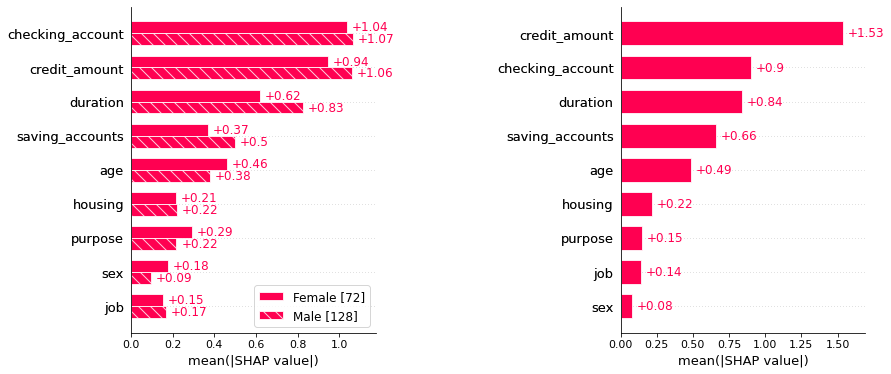

Affected Attribute Comparison
Average Comparison to True Class Members


Average Comparison to All Members


Random Affected Decision Process


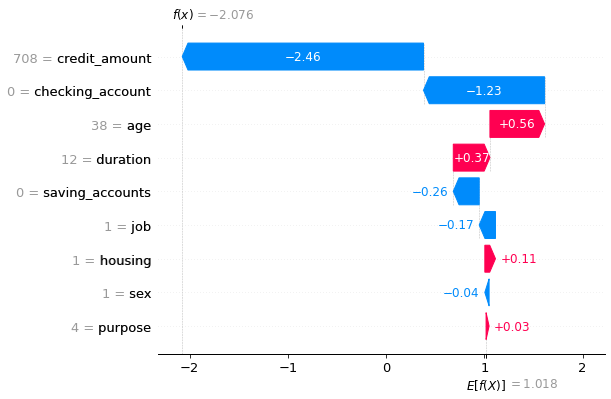

In [34]:
sensitive = 'sex' # sensible variable one wants to test for biases
labels = {0:'Female',1:'Male'} # 0 - Female and 1 - Male
fd.understand_shap(X_test,y_test,model, labels,'sex',1,0)

Observing the graph on the left, we can see the overall feature importance, and on the right, we see the importance of the isolated male, false-negative cases. In general, it seems as though the same factors are considered at roughly the same weight between genders. However, we do notice a larger gap within duration seeing that it is of higher importance to the model with males. Comparing the graph to the isolated FN cases, we immediately notice a big difference in importance between the credit amount observed in the overall outputs as opposed to the subgroup. It is a clear indication that a certain sub characteristic of the male FN group is contributing to the incorrect labels.

Selecting a random case, we can immediately see our hypothesis in play, as the credit amount of the individual had a significant influence on the model’s decision to predict the candidate as having low risk. However, noticing their checking account label of 0, and cross-checking it with our dataset original labels, we are aware of the candidate being labeled as having a “little” checking account.

Looking at another random case we again see a similar picture. Although the candidate has a very small checking account, the credit amount and duration pushed the model towards a low-credit risk classification.

Finally, by looking at the differences in the average values of the three primary model factors, we can see that the average male, incorrectly labeled as being of low risk tends to have lower checking account labels, a higher credit amount, as well as duration as opposed to people who were correctly labeled as having no risk. Moving into the final “act” stage of our ramework, we can hypothesize that certain men, with small checking accounts, but with higher than average credit amounts and durations could be subject to further inspection to minimize the privilege and minimize risk for the bank. Finally, to culminate the research results, we go into our final case of the synthetic credit card approval dataset in which we will use a Neural Network to cover another model and provide a different view of opaqueness.